In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import pystan, pickle

from pystan_cache.pystan_cache import caching_stan

# models 

In [4]:
gp_multi_missing = caching_stan.stan_model(file='models/gp_multi_missing.stan')

In [5]:
gp_multi_sim = caching_stan.stan_model(file='models/gp_multi_sim.stan')

In [335]:
gp_multi = caching_stan.stan_model(file='models/gp_multi.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_91c9aa881daa25d946f0ef7aac01292f NOW.


# simulations 

In [7]:
# fixed effect

# sim_data = {
#     'N': 1000,
#     'P':3,
#     'K':2,
#     'length_scale': 0.18,
#     'alpha': 1,
#     'sigma': .32,
#     'design': [[1,1],[1,0],[1,-1]]
# }

In [286]:
# random effect

p = 10
n = 100

design = np.zeros((p, 1+p))
design[:,0] = 1
design[:,1:] = np.eye(p)

sim_data = {
    'N': n,
    'P':p,
    'K':p+1,
    'L':2,
    'prior':[1] + [2]*p,    
    'length_scale': [1, .5],
    'alpha': [1,.4],
    'sigma': .2,
    'design': design #[[1,1,0,0],[1,0,1,0],[1,0,0,1]]
}

In [287]:
sample = gp_multi_sim.sampling(algorithm='Fixed_param', iter=1, chains=1, data=sim_data).extract()

In [288]:
x, y, f = sample['x'][0,:], sample['y'][0,:], sample['f'][0,:]

ind = np.argsort(x)

x = x[ind]
y = y[:,ind]
f = f[:,ind]

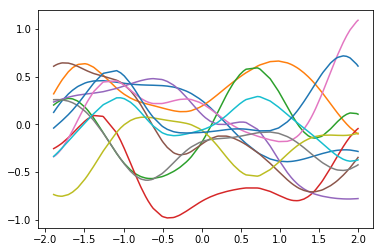

In [289]:
# plt.plot(x,y.T)
plt.plot(x,f.T)

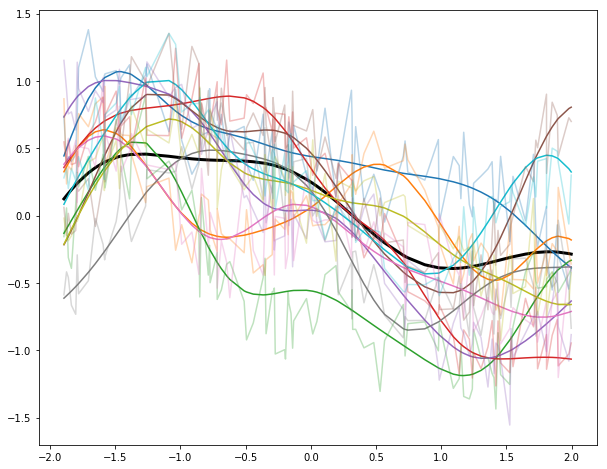

In [290]:
plt.figure(figsize=(10,8))

plt.plot(x, f[0,:], lw=3, c='k')

for i in range(len(sim_data['design'])):
    plt.plot(x,np.dot(sim_data['design'][i],f))
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.plot(x,y[i,:],alpha=.3)

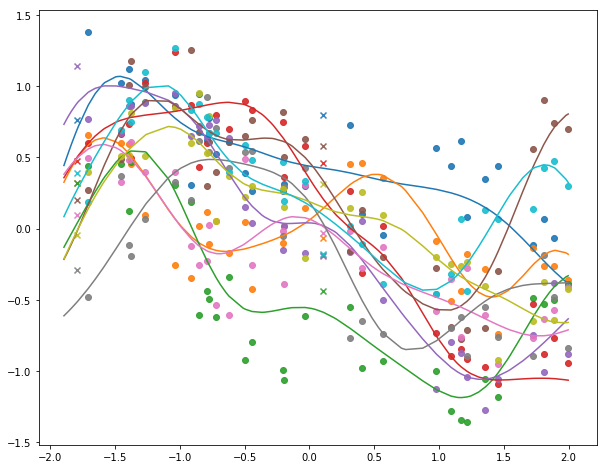

In [291]:
train_ind = np.random.choice(np.arange(sim_data['N']), size=30, replace=False)
# train_ind = np.arange(0,sim_data['N'],20)

# test_ind = [i for i in np.arange(sim_data['N']) if i not in train_ind ]
test_ind = np.arange(5,sim_data['N'],50)

train_ind.sort()
test_ind.sort()

plt.figure(figsize=(10,8))

for i in range(len(sim_data['design'])):
    plt.plot(x,np.dot(sim_data['design'][i],f))
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.scatter(x[train_ind],y[i,train_ind],alpha=.9)
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.scatter(x[test_ind],y[i,test_ind],alpha=.9, marker='x')
    
# plt.scatter(x[test_ind], y[:,test_ind]);
# plt.scatter(x[train_ind], y[:,train_ind],s=100);
# plt.plot(x,f, c='k', lw=3);

In [292]:
train_data = sim_data.copy()
train_data['N'] = len(train_ind)
train_data['y'] = y[:,train_ind]
train_data['x'] = x[train_ind]

train_data['alpha_prior'] = [[1,1], [1,1]]
train_data['length_scale_prior'] = [[1,1], [1,1]]

In [354]:
tsamples = gp_multi.sampling(data=train_data, chains=2, iter=4000, control = {'adapt_delta': 0.8})

In [355]:
print tsamples

Inference for Stan model: anon_model_91c9aa881daa25d946f0ef7aac01292f.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
length_scale[0]   0.99    0.02   0.51   0.39   0.65   0.85   1.21   2.28  475.0   1.01
length_scale[1]   0.56  3.6e-3   0.07   0.43   0.51   0.56   0.61    0.7  353.0   1.02
alpha[0]          0.45  8.1e-3   0.21   0.18    0.3    0.4   0.54   1.01  681.0   1.01
alpha[1]          0.43  1.6e-3   0.05   0.34   0.39   0.43   0.46   0.55 1071.0    1.0
sigma             0.21  1.6e-4   0.01   0.19    0.2   0.21   0.22   0.23 4000.0    1.0
f_eta[0,0]        1.05    0.01    0.5   0.27   0.69   0.99   1.34   2.19 2228.0    1.0
f_eta[1,0]        1.62  9.1e-3   0.47   0.71   1.29   1.61   1.93   2.56 2655.0    1.0
f_eta[2,0]         0.5  9.0e-3   0.45  -0.39   0.19    0.5    0.8   1.41 2577.0    1.0
f_eta[3,0]        0.01  9.6e

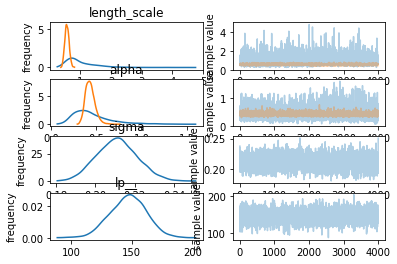

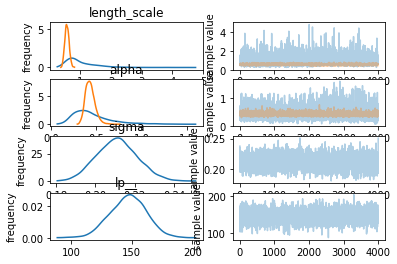

In [356]:
tsamples.plot(['length_scale', 'alpha', 'sigma','lp__'])

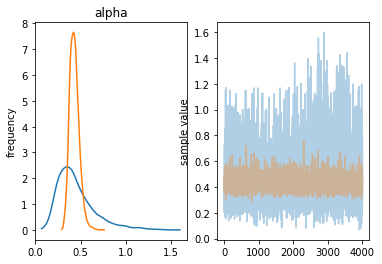

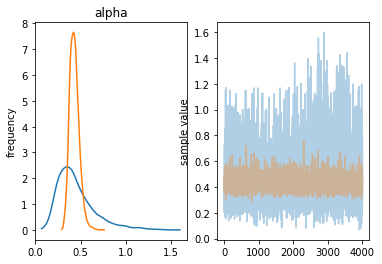

In [357]:
tsamples.plot(['alpha',])

In [358]:
tsamp = tsamples.extract(permuted=True)

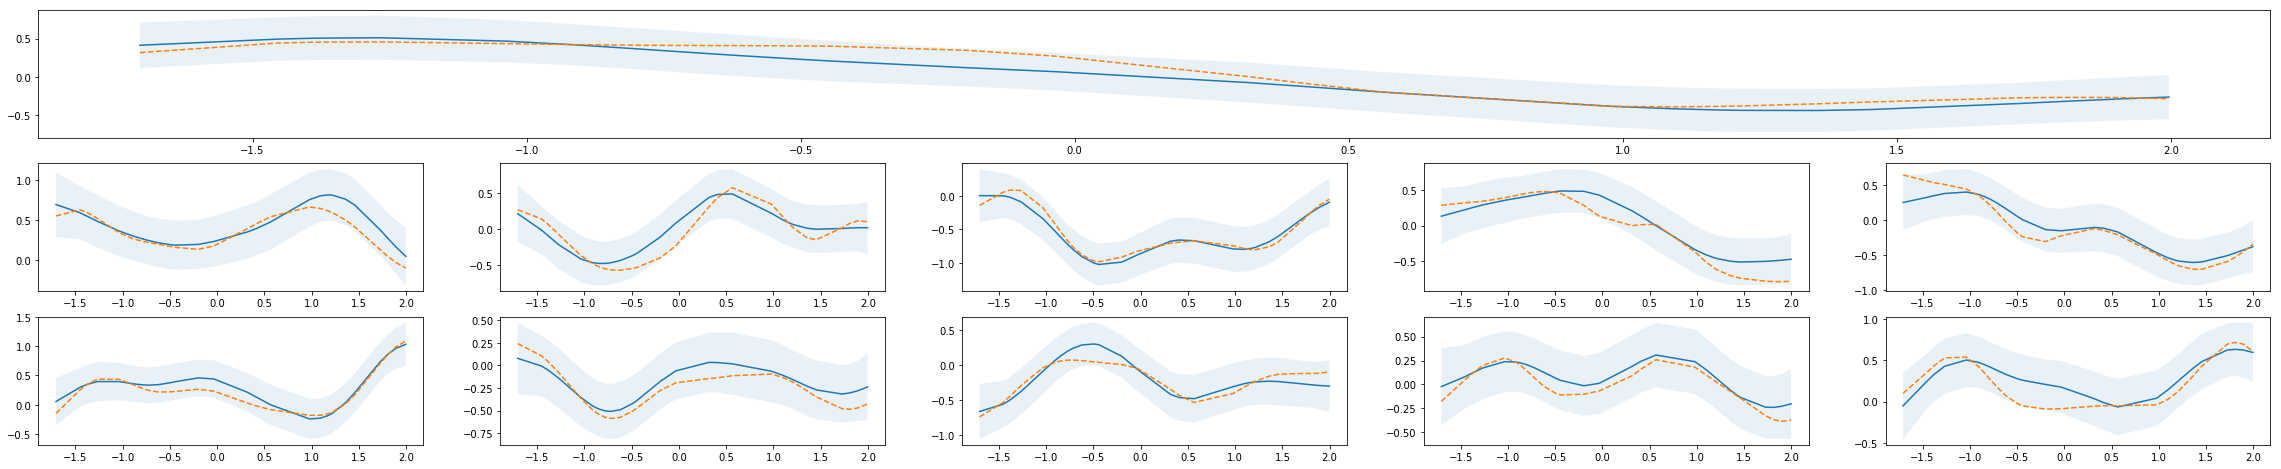

In [359]:
plt.figure(figsize=(4*p,8))

ncol = 5
nrow = int(1.*(f.shape[0]-1)/ncol) + 1

for i in range(f.shape[0]):
    
    if i == 0:
        plt.subplot2grid((nrow,ncol),(0,0),colspan=ncol)
    else:
        plt.subplot2grid((nrow,ncol),(1+(i-1)/ncol,(i-1)%ncol))
    
    plt.plot(x[train_ind], tsamp['f'][:,i,:].mean(0),)
    plt.fill_between(x[train_ind], 
                     tsamp['f'][:,i,:].mean(0)-2*tsamp['f'][:,i,:].std(0),
                     tsamp['f'][:,i,:].mean(0)+2*tsamp['f'][:,i,:].std(0),alpha=.1)
    
    plt.plot(x[train_ind],f[i,train_ind].T,'--')

In [360]:
null_train_data = train_data.copy()

null_train_data['K'] = 1
null_train_data['L'] = 1
null_train_data['design'] = [[1]]*p
null_train_data['prior'] = [1]

null_train_data['alpha_prior'] = [[1, 1]]
null_train_data['length_scale_prior'] = [[1, 1]]

In [361]:
null_tsamples = gp_multi.sampling(data=null_train_data, chains=2, iter=2000, control = {'adapt_delta': 0.8})

In [362]:
print null_tsamples

Inference for Stan model: anon_model_91c9aa881daa25d946f0ef7aac01292f.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
length_scale[0]   1.11    0.03   0.47    0.5   0.75    1.0   1.37   2.33  187.0   1.01
alpha[0]          0.55    0.02   0.27   0.24   0.36   0.48   0.65   1.23  179.0   1.01
sigma             0.46  4.5e-4   0.02   0.43   0.45   0.46   0.48    0.5 2000.0    1.0
f_eta[0,0]        1.18    0.02   0.49   0.44   0.83   1.12   1.47   2.29  711.0    1.0
f_eta[0,1]        0.47    0.03   0.67  -0.69-1.3e-3   0.39   0.88   1.94  520.0    1.0
f_eta[0,2]       -0.44    0.02   0.79  -2.03  -0.96  -0.45   0.08   1.06 1188.0    1.0
f_eta[0,3]       -0.26    0.02   0.85  -1.91  -0.84  -0.26   0.33    1.4 2000.0    1.0
f_eta[0,4]       -0.02    0.02   0.88   -1.7  -0.62  -0.03    0.6   1.72 2000.0    1.0
f_eta[0,5]        -0.1    0.

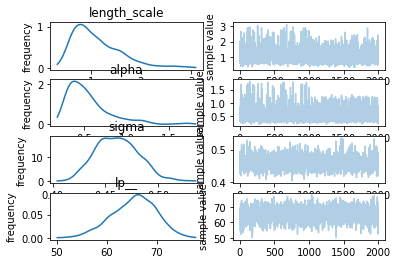

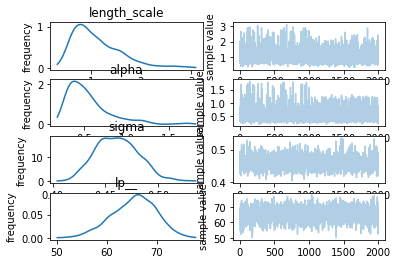

In [363]:
null_tsamples.plot(['length_scale', 'alpha', 'sigma','lp__'])

In [364]:
nulltsamp = null_tsamples.extract(permuted=True)

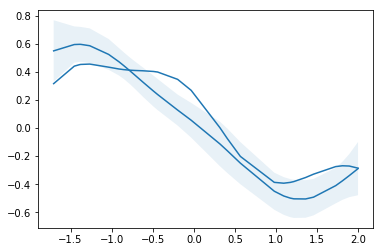

In [365]:
plt.plot(x[train_ind],f[0,train_ind].T)

plt.gca().set_prop_cycle(None)

plt.plot(x[train_ind], nulltsamp['f'][:,0,:].mean(0))
    
plt.gca().set_prop_cycle(None)

plt.fill_between(x[train_ind], 
                 nulltsamp['f'][:,0,:].mean(0)-2*nulltsamp['f'][:,0,:].std(0),
                 nulltsamp['f'][:,0,:].mean(0)+2*nulltsamp['f'][:,0,:].std(0),alpha=.1)

In [366]:
1.*sum(
        (nulltsamp['f'][:,0,:].mean(0)-2*nulltsamp['f'][:,0,:].std(0) < f[0,train_ind]) 
        & 
        (nulltsamp['f'][:,0,:].mean(0)+2*nulltsamp['f'][:,0,:].std(0) > f[0,train_ind])
)/len(train_ind)

0.5666666666666667

In [367]:
1.*sum(
        (tsamp['f'][:,0,:].mean(0)-2*tsamp['f'][:,0,:].std(0) < f[0,train_ind]) 
        & 
        (tsamp['f'][:,0,:].mean(0)+2*tsamp['f'][:,0,:].std(0) > f[0,train_ind])
)/len(train_ind)

1.0

In [353]:
sim_data['alpha'][0]/sum(sim_data['alpha'])

0.7142857142857143

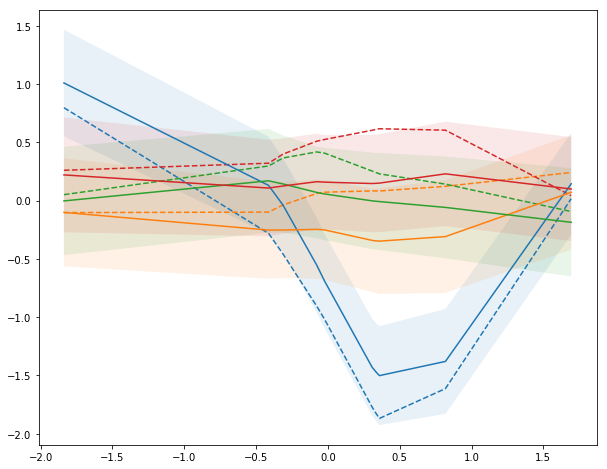

In [90]:
plt.figure(figsize=(10,8))

plt.plot(x[train_ind],f[:,train_ind].T,'--')

plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.plot(x[train_ind], tsamp['f'][:,i,:].mean(0),)
    
plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.fill_between(x[train_ind], 
                     tsamp['f'][:,i,:].mean(0)-2*tsamp['f'][:,i,:].std(0),
                     tsamp['f'][:,i,:].mean(0)+2*tsamp['f'][:,i,:].std(0),alpha=.1)

In [16]:
# test with no missing data

train_data = sim_data.copy()
train_data['N'] = len(train_ind)
train_data['y'] = y[:,train_ind]
train_data['x'] = x[train_ind]

train_data['N_mis'] = 0
train_data['x_mis'] = []

tsamples = gp_multi_missing.sampling(data=train_data, chains=4, iter=2000, control = {'adapt_delta': 0.95})

In [17]:
tsamp = tsamples.extract(permuted=True)

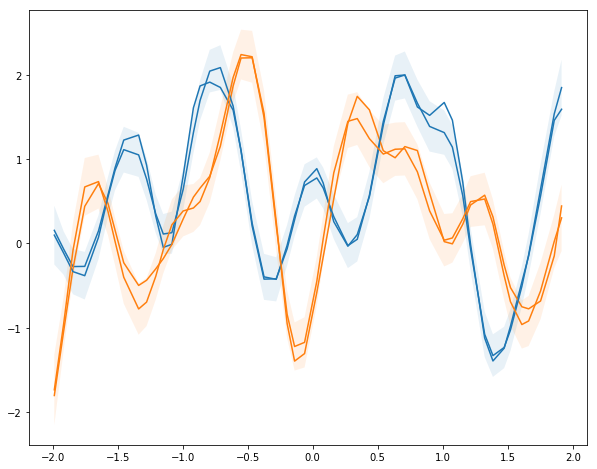

In [18]:
plt.figure(figsize=(10,8))

plt.plot(x[train_ind],f[:,train_ind].T)

plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.plot(x[train_ind], tsamp['f'][:,i,:].mean(0))
    
plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.fill_between(x[train_ind], 
                     tsamp['f'][:,i,:].mean(0)-2*tsamp['f'][:,i,:].std(0),
                     tsamp['f'][:,i,:].mean(0)+2*tsamp['f'][:,i,:].std(0),alpha=.1)

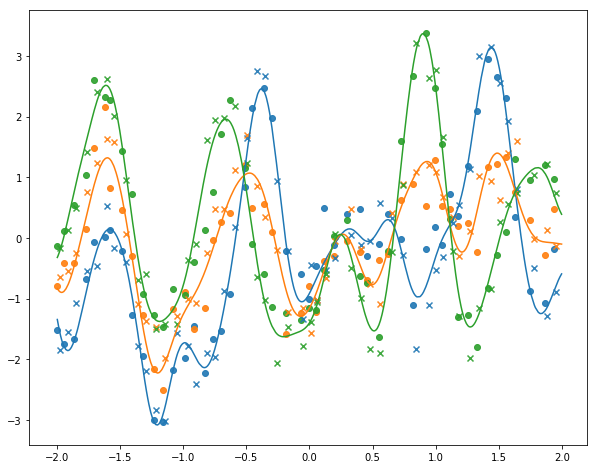

In [51]:
# train_ind = np.random.choice(np.arange(sim_data['N']), size=50, replace=False)
train_ind = np.arange(0,sim_data['N'],20)

# test_ind = [i for i in np.arange(sim_data['N']) if i not in train_ind ]
test_ind = np.arange(5,sim_data['N'],20)

train_ind.sort()
test_ind.sort()

plt.figure(figsize=(10,8))

for i in range(len(sim_data['design'])):
    plt.plot(x,np.dot(sim_data['design'][i],f))
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.scatter(x[train_ind],y[i,train_ind],alpha=.9)
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.scatter(x[test_ind],y[i,test_ind],alpha=.9, marker='x')

In [52]:
train_data = sim_data.copy()
train_data['N'] = len(train_ind)
train_data['y'] = y[:,train_ind]
train_data['x'] = x[train_ind]

train_data['N_mis'] = len(test_ind)
train_data['x_mis'] = x[test_ind]

train_data['N_mis']

50

In [53]:
tsamples = gp_multi_missing.sampling(data=train_data, chains=4, iter=2000, control = {'adapt_delta': 0.95})

In [54]:
tsamp = tsamples.extract(permuted=True)

In [55]:
tsamp.keys()

[u'length_scale',
 u'alpha',
 u'sigma',
 u'f_eta',
 u'y_mis',
 u'f',
 u'y_tot',
 u'lp__']

In [56]:
all_ind = np.array(train_ind.tolist() + test_ind.tolist())

sort = np.argsort(all_ind)

all_ind = all_ind[sort]

# np.argsort(all_ind)
all_ind

array([  0,   5,  20,  25,  40,  45,  60,  65,  80,  85, 100, 105, 120,
       125, 140, 145, 160, 165, 180, 185, 200, 205, 220, 225, 240, 245,
       260, 265, 280, 285, 300, 305, 320, 325, 340, 345, 360, 365, 380,
       385, 400, 405, 420, 425, 440, 445, 460, 465, 480, 485, 500, 505,
       520, 525, 540, 545, 560, 565, 580, 585, 600, 605, 620, 625, 640,
       645, 660, 665, 680, 685, 700, 705, 720, 725, 740, 745, 760, 765,
       780, 785, 800, 805, 820, 825, 840, 845, 860, 865, 880, 885, 900,
       905, 920, 925, 940, 945, 960, 965, 980, 985])

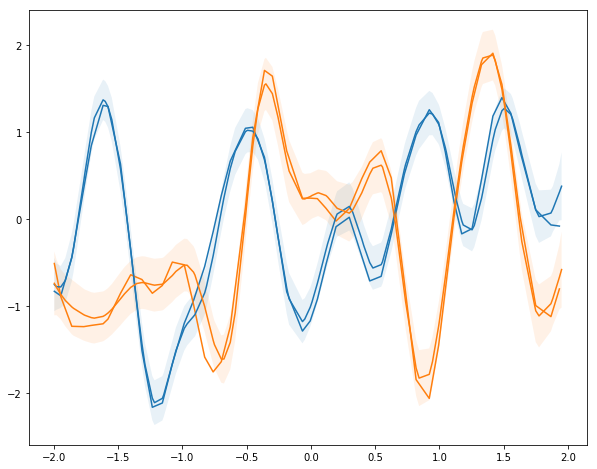

In [57]:
plt.figure(figsize=(10,8))

plt.plot(x[train_ind],f[:,train_ind].T)

plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.plot(x[all_ind], tsamp['f'][:,i,sort].mean(0))
    
plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.fill_between(x[all_ind], 
                     tsamp['f'][:,i,sort].mean(0)-2*tsamp['f'][:,i,sort].std(0),
                     tsamp['f'][:,i,sort].mean(0)+2*tsamp['f'][:,i,sort].std(0),alpha=.1)